In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0,), (1,))])

batch_size = 64

trainset = torchvision.datasets.FashionMNIST(root='data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='data',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.4MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_chanel, out_chanel):
        super().__init__()

        self.l = torch.nn.Sequential(
            torch.nn.Conv2d(in_chanel, out_chanel, 3, 1, 1),
            torch.nn.BatchNorm2d(out_chanel),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.15),
            torch.nn.Conv2d(out_chanel, out_chanel, 3, 1, 1),
            torch.nn.BatchNorm2d(out_chanel),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.15),
        )

    def forward(self, x):
        return self.l(x)


class CNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.convB1 = ConvBlock(1, 32)
        self.convB2 = ConvBlock(32, 64)
        self.convB3 = ConvBlock(64, 128)
        self.convB4 = ConvBlock(128, 256)

        self.mapping1 = torch.nn.Linear(32, 2)
        self.mapping2 = torch.nn.Linear(64, 2)
        self.mapping3 = torch.nn.Linear(128, 2)
        self.mapping4 = torch.nn.Linear(256, 2)

        self.cls1 = torch.nn.Linear(2, 10)
        self.cls2 = torch.nn.Linear(2, 10)
        self.cls3 = torch.nn.Linear(2, 10)
        self.cls4 = torch.nn.Linear(2, 10)

        self.fc_model = torch.nn.Linear(256, 10)

    def forward(self, x):
        x1 = self.convB1(x)
        x1 = torch.nn.functional.max_pool2d(x1, 2, 2)

        x2 = self.convB2(x1)
        x2 = torch.nn.functional.max_pool2d(x2, 2, 2)

        x3 = self.convB3(x2)
        x3 = torch.nn.functional.max_pool2d(x3, 2, 2)

        x4 = self.convB4(x3)
        x4 = torch.nn.functional.max_pool2d(x4, 2, 2)

        out = torch.mean(x4, dim=[-1, -2])
        out = self.fc_model(out)

        x1 = x1.mean(dim=[-1, -2])
        x2 = x2.mean(dim=[-1, -2])
        x3 = x3.mean(dim=[-1, -2])
        x4 = x4.mean(dim=[-1, -2])

        x1 = self.mapping1(x1)
        x2 = self.mapping2(x2)
        x3 = self.mapping3(x3)
        x4 = self.mapping4(x4)

        o1 = self.cls1(x1)
        o2 = self.cls2(x2)
        o3 = self.cls3(x3)
        o4 = self.cls4(x4)

        return [x1, x2, x3, x4], [o1, o2, o3, o4], out

model = CNNModel()

model

CNNModel(
  (convB1): ConvBlock(
    (l): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.15, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.15, inplace=False)
    )
  )
  (convB2): ConvBlock(
    (l): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.15, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNNModel(
  (convB1): ConvBlock(
    (l): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.15, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.15, inplace=False)
    )
  )
  (convB2): ConvBlock(
    (l): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.15, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.

In [ ]:
with SummaryWriter() as writer:
    i = 0
    best_loss = np.inf
    best_model = None
    for epoch in range(22):
        print(f"\n------------------ Epoch {epoch} ------------------")

        model.train()
        epoch_train_loss = 0.0
        for x, y in tqdm(trainloader, desc="Training"):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            _, [o1, o2, o3, o4], output = model(x)

            loss = loss_function(output, y)
            loss += loss_function(o1, y)
            loss += loss_function(o2, y)
            loss += loss_function(o3, y)
            loss += loss_function(o4, y)
            loss = loss / 5

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            writer.add_scalar("train/loss", loss.item(), i)
            i += 1

        avg_train_loss = epoch_train_loss / len(trainloader)
        print(f"Train Loss: {avg_train_loss:.4f}")

        model.eval()
        sum_loss = 0
        sum_correct = 0
        sum_samples = 0
        with torch.no_grad():
            for x, y in tqdm(testloader, desc="Testing"):
                x = x.to(device)
                y = y.to(device)

                _, _, output = model(x)
                loss = loss_function(output, y)

                sum_loss += loss.item() * len(y)
                sum_samples += len(y)
                sum_correct += (output.argmax(dim=1) == y).sum().item()

        test_loss = sum_loss / sum_samples
        test_acc = sum_correct / sum_samples

        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc * 100:.2f}%")

        writer.add_scalar("test/loss", test_loss, epoch)
        writer.add_scalar("test/accuracy", test_acc, epoch)

        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict()
            torch.save(best_model, "best_model.pth")
            print("New best model saved!")

model.load_state_dict(best_model)


------------------ Epoch 0 ------------------


<ipython-input-5-7661de6f6136>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, y in tqdm(trainloader, desc="Training"):


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 1.0999


<ipython-input-5-7661de6f6136>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, y in tqdm(testloader, desc="Testing"):


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.3145
Test Accuracy: 88.83%
New best model saved!

------------------ Epoch 1 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.7283


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.3003
Test Accuracy: 89.62%
New best model saved!

------------------ Epoch 2 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.6315


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2659
Test Accuracy: 90.28%
New best model saved!

------------------ Epoch 3 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.5779


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2461
Test Accuracy: 91.01%
New best model saved!

------------------ Epoch 4 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.5378


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2335
Test Accuracy: 91.06%
New best model saved!

------------------ Epoch 5 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.5096


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2356
Test Accuracy: 91.44%

------------------ Epoch 6 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.4886


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2234
Test Accuracy: 91.79%
New best model saved!

------------------ Epoch 7 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.4707


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2061
Test Accuracy: 92.74%
New best model saved!

------------------ Epoch 8 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.4549


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2159
Test Accuracy: 92.52%

------------------ Epoch 9 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.4426


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2062
Test Accuracy: 92.40%

------------------ Epoch 10 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.4271


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2230
Test Accuracy: 91.99%

------------------ Epoch 11 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.4195


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.1993
Test Accuracy: 92.78%
New best model saved!

------------------ Epoch 12 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.4077


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.1893
Test Accuracy: 93.16%
New best model saved!

------------------ Epoch 13 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.3997


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2030
Test Accuracy: 93.06%

------------------ Epoch 14 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.3906


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2001
Test Accuracy: 92.76%

------------------ Epoch 15 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.3830


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2192
Test Accuracy: 92.03%

------------------ Epoch 16 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.3776


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.1986
Test Accuracy: 92.81%

------------------ Epoch 17 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.3708


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.1922
Test Accuracy: 93.26%

------------------ Epoch 18 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.3645


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2048
Test Accuracy: 92.88%

------------------ Epoch 19 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.3595


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2037
Test Accuracy: 92.99%

------------------ Epoch 20 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.3534


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.1934
Test Accuracy: 93.35%

------------------ Epoch 21 ------------------


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.3489


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.2040
Test Accuracy: 93.32%


<All keys matched successfully>

In [ ]:
##torch.save(model.state_dict, "fashion-mnist_out2d_linear_detached.pth")

In [ ]:
##model.load_state_dict(copy.deepcopy(torch.load("fashion-mnist_out2d_linear.pth", device)))

In [ ]:
print(best_loss)

0.18929744502305984


In [ ]:
features1 = []
features2 = []
features3 = []
features4 = []
outputs = []
labels = []

for x, y in tqdm(testloader):
    x = x.to(device)

    with torch.no_grad():
        [f1, f2, f3, f4], _, out = model(x)

    labels.append(y.numpy())
    features1.append(f1.cpu().numpy())
    features2.append(f2.cpu().numpy())
    features3.append(f3.cpu().numpy())
    features4.append(f4.cpu().numpy())
    outputs.append(out.argmax(dim=-1).cpu().numpy())


<ipython-input-12-db2ff6b982e3>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, y in tqdm(testloader):


  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
features1 = np.vstack(features1)
features2 = np.vstack(features2)
features3 = np.vstack(features3)
features4 = np.vstack(features4)
outputs = np.hstack(outputs)
labels = np.hstack(labels)

print(features1.shape)
print(features2.shape)
print(features3.shape)
print(features4.shape)
print(outputs.shape)
print(labels.shape)

(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000,)
(10000,)


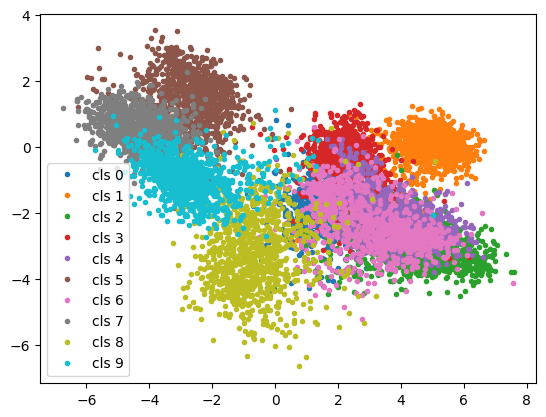

In [ ]:
for i in range(10):
    plt.plot(features1[labels == i, 0], features1[labels == i, 1], '.', label=f'cls {i}')

plt.legend()

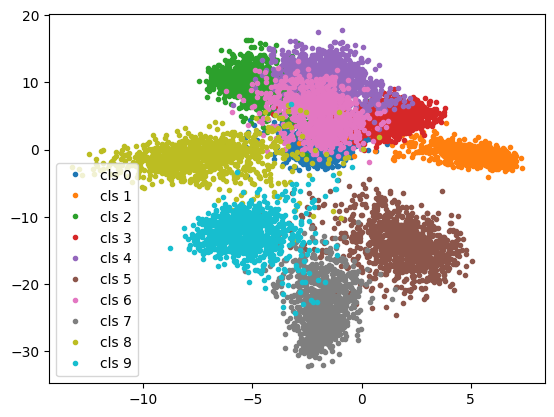

In [ ]:
for i in range(10):
    plt.plot(features2[labels == i, 0], features2[labels == i, 1], '.', label=f'cls {i}')

plt.legend()

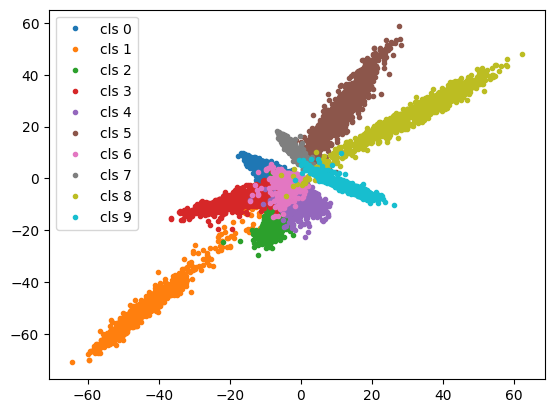

In [ ]:
for i in range(10):
    plt.plot(features3[labels == i, 0], features3[labels == i, 1], '.', label=f'cls {i}')

plt.legend()

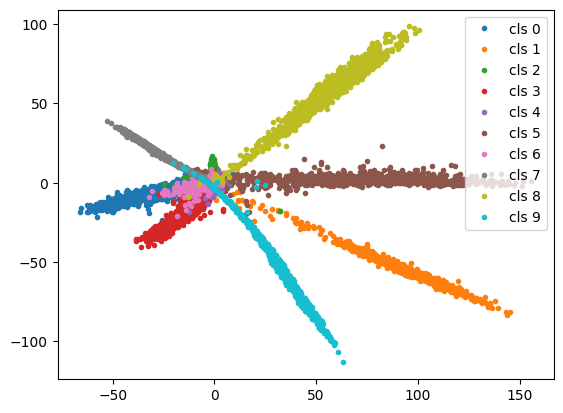

In [ ]:
for i in range(10):
    plt.plot(features4[labels == i, 0], features4[labels == i, 1], '.', label=f'cls {i}')

plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(labels, outputs)
print(cm)

[[897   0  25   5   1   1  68   0   3   0]
 [  0 986   0   7   4   0   2   0   1   0]
 [  9   1 934   5  20   0  31   0   0   0]
 [ 12   1  13 931  24   0  19   0   0   0]
 [  0   0  53  13 878   0  56   0   0   0]
 [  0   0   0   0   0 951   0  39   1   9]
 [ 92   0  55  17  39   0 795   0   2   0]
 [  0   0   0   0   0   0   0 987   0  13]
 [  2   0   2   1   2   1   0   0 992   0]
 [  0   0   0   0   0   3   0  15   1 981]]


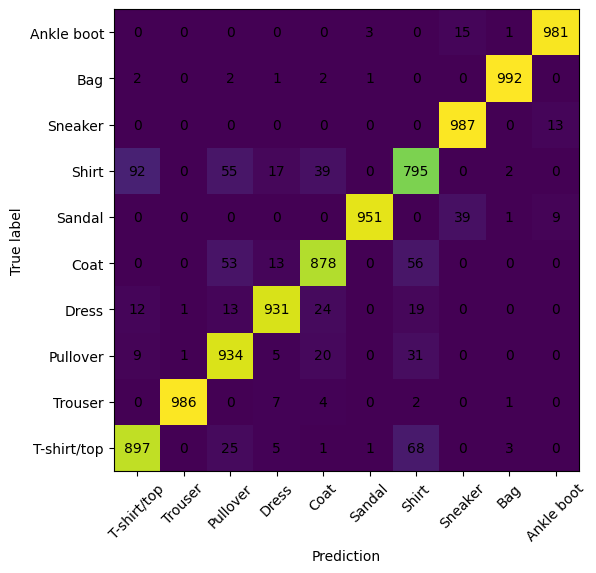

In [ ]:
plt.figure(figsize=(6, 6))
plt.pcolormesh(cm)
plt.yticks(np.arange(10) + 0.5, classes)
plt.xticks(np.arange(10) + 0.5, classes, rotation=45)

for (i, j), z in np.ndenumerate(cm):
    plt.text(j + 0.5, i + 0.5, f'{z}', ha='center', va='center')

plt.ylabel("True label")
plt.xlabel("Prediction")
plt.show()